In [0]:
from fastai.collab import *
from fastai.tabular import *

In [0]:
user,item,title = 'userId','movieId','title'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
path_data = "/content/drive/My Drive/ml-100k/u.data"

In [5]:
ratings = pd.read_csv(path_data, delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
path_item = "/content/drive/My Drive/ml-100k/u.item"

In [7]:
movies = pd.read_csv(path_item,  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [8]:
len(ratings)

100000

In [9]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [0]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [11]:
data.show_batch()

userId,title,target
286,Raiders of the Lost Ark (1981),4.0
733,Heat (1995),4.0
751,Eraser (1996),2.0
416,Cool Runnings (1993),3.0
60,They Made Me a Criminal (1939),5.0


In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


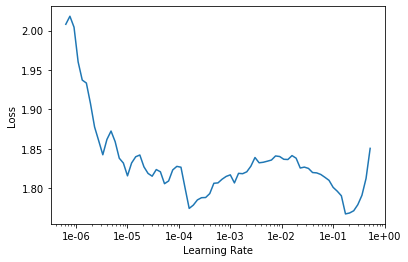

In [14]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [15]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.938342,0.950220,00:09
1,0.855565,0.890425,00:09
2,0.777465,0.837364,00:09
3,0.663846,0.812185,00:09
4,0.554260,0.811192,00:09


In [0]:
learn.save('dotprod')

<h2>Analysis</h2>

In [0]:
learn.load('dotprod');

In [19]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [20]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

In [23]:
g

title
'Til There Was You (1997)                  9
1-900 (1994)                               5
101 Dalmatians (1996)                    109
12 Angry Men (1957)                      125
187 (1997)                                41
                                        ... 
Young Guns II (1990)                      44
Young Poisoner's Handbook, The (1995)     41
Zeus and Roxanne (1997)                    6
unknown                                    9
Á köldum klaka (Cold Fever) (1994)         1
Name: rating, Length: 1664, dtype: int64

<h2>Bias</h2>

In [25]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [0]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]


In [27]:
mean_ratings

title
'Til There Was You (1997)                2.333333
1-900 (1994)                             2.600000
101 Dalmatians (1996)                    2.908257
12 Angry Men (1957)                      4.344000
187 (1997)                               3.024390
                                           ...   
Young Guns II (1990)                     2.772727
Young Poisoner's Handbook, The (1995)    3.341463
Zeus and Roxanne (1997)                  2.166667
unknown                                  3.444444
Á köldum klaka (Cold Fever) (1994)       3.000000
Name: rating, Length: 1664, dtype: float64

In [0]:
item0 = lambda o:o[0]

In [30]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3813),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3568),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2719), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2706), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2545), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2521), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2497), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2462), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2373), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2351), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2269), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2257), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2167), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2158), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2122), 'Lawnmower 

In [31]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6077), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5842), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5669), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5616), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5568), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5327), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5189), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4994), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4978), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4897), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4712), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4687), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4675), "One Flew Over the Cuckoo's Nest (1975)", 4.291666666666667),
 (tensor(0.4541), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4535), 'To Kill a Mockingbird (1962)', 4.292237442922374)]

<h2>Weights</h2>

In [32]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape


torch.Size([1000, 40])

In [33]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [0]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [35]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.3075), 'Jungle2Jungle (1997)'),
 (tensor(1.2797), 'Home Alone 3 (1997)'),
 (tensor(1.1827), 'Leave It to Beaver (1997)'),
 (tensor(1.1513), 'Congo (1995)'),
 (tensor(1.1311), "McHale's Navy (1997)"),
 (tensor(1.1191), 'D3: The Mighty Ducks (1996)'),
 (tensor(1.0935), 'Grease 2 (1982)'),
 (tensor(1.0925), 'Bio-Dome (1996)'),
 (tensor(1.0629), 'Children of the Corn: The Gathering (1996)'),
 (tensor(1.0545), 'Batman & Robin (1997)')]

In [36]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.0984), 'Wrong Trousers, The (1993)'),
 (tensor(-1.0879), 'Close Shave, A (1995)'),
 (tensor(-1.0627), 'Lawrence of Arabia (1962)'),
 (tensor(-1.0282), 'Casablanca (1942)'),
 (tensor(-1.0144), 'Chinatown (1974)'),
 (tensor(-1.0134), 'Third Man, The (1949)'),
 (tensor(-1.0114),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(-0.9895), 'Ran (1985)'),
 (tensor(-0.9584), 'Some Folks Call It a Sling Blade (1993)'),
 (tensor(-0.9443), 'Apocalypse Now (1979)')]

In [0]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [38]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1364), 'Braveheart (1995)'),
 (tensor(1.0621), 'Raiders of the Lost Ark (1981)'),
 (tensor(1.0124), 'Titanic (1997)'),
 (tensor(0.9562), "It's a Wonderful Life (1946)"),
 (tensor(0.8933), 'Forrest Gump (1994)'),
 (tensor(0.8854), 'Star Wars (1977)'),
 (tensor(0.8754), 'American President, The (1995)'),
 (tensor(0.8524), 'Return of the Jedi (1983)'),
 (tensor(0.8523), 'Sleepless in Seattle (1993)'),
 (tensor(0.8481), 'Hunt for Red October, The (1990)')]

In [39]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.9019), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.8789), 'Keys to Tulsa (1997)'),
 (tensor(-0.8060), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(-0.8016), 'Beavis and Butt-head Do America (1996)'),
 (tensor(-0.7950), 'Jude (1996)'),
 (tensor(-0.7905), 'Trainspotting (1996)'),
 (tensor(-0.7502), 'Lost Highway (1997)'),
 (tensor(-0.7454), 'Serial Mom (1994)'),
 (tensor(-0.7245), 'Brazil (1985)'),
 (tensor(-0.7182), 'Very Brady Sequel, A (1996)')]

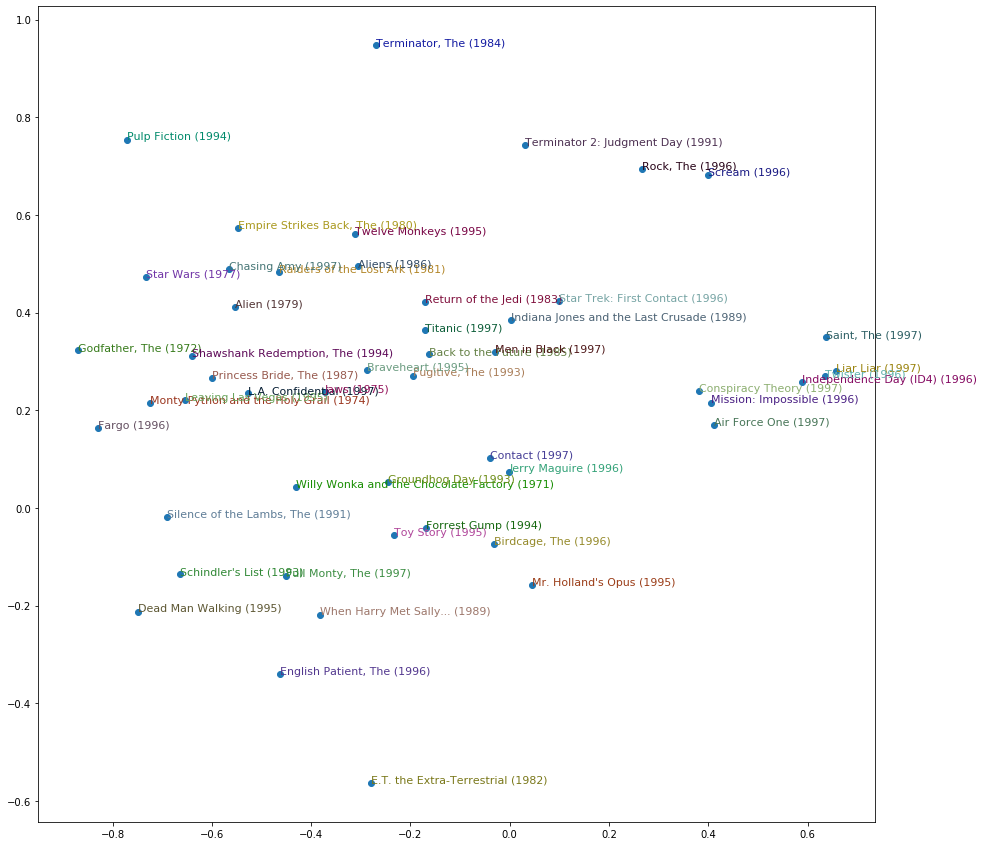

In [40]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()